# Synthetic V1: Klein bottle

Lead author: Sofia Gonzalez.

The Klein bottle may be constructed from the symmetry properties of simple cell receptive fields in V1 (See _Looking into a Klein bottle_ by _Nicholas V. Swindale_). <br>
The notion of Klein bottle, written $\mathbb{K}$, refers to any topological space homeomorphic to that obtained by identification in a full square of the opposite sides with a change of direction for one of the pairs. Group theoretically speaking:<br>
\begin{align*}
         &  (x_1,y_1) \sim (x_2, y_2) \\
         \Leftrightarrow \quad &  y_1-y_2 \in \mathbb Z
                                 \text{ and } x_1-x_2 \in 2\mathbb Z \\
         \text{ or } \quad &
        y_1 + y_2 \in \mathbb Z \text{ and } x_1-x_2 \in \mathbb Z\setminus 2\mathbb Z.
\end{align*}

The intrinsic dimension of the Klein function is 2. This is what _geomstats_ outputs by default when generating random points on its surface. However, we can play with its different parametrizations to work with it in a more intuitive way. It cannot be embedded in $\mathbb{R}^3$, but only immerged with a self-intersection. The smallest number of dimensions required to embed the Klein bottle is 4. <br>
However, we can construct different parametrizations in $\mathbb{R}^3$ in order to visualize its properties better. The three main 3D parametrizations are: <br>
- Klein bottle
- Klein bagel
- Pinched torus

### Set-up + Imports

In [2]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import neurometry.curvature.viz as viz


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch

import numpy as np
from ripser import ripser
from persim import plot_diagrams

import gtda

import neurometry.curvature.persistent_homology as persistent_homology
from gtda.homology import WeakAlphaPersistence
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram, plot_heatmap

Working directory:  /home/sghomedir/Desktop/github/neurometry/neurometry
Directory added to path:  /home/sghomedir/Desktop/github/neurometry
Directory added to path:  /home/sghomedir/Desktop/github/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


ImportError: /home/sghomedir/anaconda3/envs/neurometry/lib/python3.11/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/sghomedir/anaconda3/envs/neurometry/lib/python3.11/site-packages/giotto_ph-0.2.2-py3.11-linux-x86_64.egg/gph/modules/gph_ripser.cpython-311-x86_64-linux-gnu.so)

### Klein bagel parametrization

In [3]:
num_points = 5000
task_points = synthetic.klein_bottle(num_points, coords_type="bagel")

noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array(np.ones(3)),
    poisson_multiplier=50,
)

print("Initial dimension (task points):", np.shape(task_points)[1])
print("Dimension of manifold/noisy points:", np.shape(noisy_points)[1])

Initial dimension (task points): 3
Dimension of manifold/noisy points: 3


In [3]:
def plot_feature_neural_spaces(
    task_points, noisy_points, range_ax, pt_size=2, opacity=0.5, N=3
):
    x = task_points[:, 0]
    y = task_points[:, 1]
    z = task_points[:, 2]
    angles = torch.atan2(task_points[:, 1], task_points[:, 0])
    normalized_angles = angles / (2 * np.pi) + 1 / 2
    colors = plt.cm.hsv(normalized_angles)

    place_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    encoding_matrix = gs.vstack((gs.cos(place_angles), gs.sin(place_angles)))
    vectors = [encoding_matrix[:, i] for i in range(N)]

    cm = plt.get_cmap("twilight")
    vector_colors = [cm(1.0 * i / N) for i in range(N)]
    vector_colors = [
        "rgb({}, {}, {})".format(int(r * 255), int(g * 255), int(b * 255))
        for r, g, b, _ in vector_colors
    ]

    scatter1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(size=pt_size, color=colors, opacity=opacity),
        name="Data Points",
    )

    lines_and_cones = []
    for idx, (vector, color) in enumerate(zip(vectors, vector_colors)):
        lines_and_cones.append(
            go.Scatter3d(
                x=[0, vector[0]],
                y=[0, vector[1]],
                z=[0, 0],
                mode="lines",
                line=dict(color=color, width=5),
                name=f"Encoding Vector {idx+1}",
            )
        )
    lines_and_cones.append(
        go.Cone(
            x=[vector[0]],
            y=[vector[1]],
            z=[0],
            u=[vector[0] / 10],
            v=[vector[1] / 10],
            w=[0],
            showscale=False,
            colorscale=[[0, color], [1, color]],
            sizemode="absolute",
            sizeref=0.1,
        )
    )

    x = noisy_points[:, 0]
    y = noisy_points[:, 1]
    z = noisy_points[:, 2]

    print(f"mean firing rate: {torch.mean(noisy_points):.2f} Hz")

    scatter2 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(size=pt_size, color=colors, opacity=opacity),
        name="Neural activations",
    )

    fig = make_subplots(
        rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
    )

    # Add the first set of traces (scatter1 and lines_and_cones) to the first subplot
    fig.add_traces(
        [scatter1] + lines_and_cones,
        rows=[1] * (len([scatter1]) + len(lines_and_cones)),
        cols=[1] * (len([scatter1]) + len(lines_and_cones)),
    )

    # Add the second scatter (scatter2) to the second subplot
    fig.add_trace(scatter2, row=1, col=2)

    reference_frequency = 200

    fig.update_layout(
        scene1=dict(
            aspectmode="cube",
            xaxis=dict(range=[-range_ax, range_ax], title="Feature 1"),
            yaxis=dict(range=[-range_ax, range_ax], title="Feature 2"),
            zaxis=dict(range=[-range_ax, range_ax], title=""),
        ),
        scene2=dict(
            aspectmode="cube",
            xaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 1 firing rate",
            ),
            yaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 2 firing rate",
            ),
            zaxis=dict(
                range=[0, reference_frequency * 1.2],
                title="Neuron 3 firing rate",
            ),
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        title_text="",
        annotations=[
            dict(
                text="Feature Space",
                xref="paper",
                yref="paper",
                x=0.25,
                y=0.95,
                showarrow=False,
                font=dict(size=20),
            ),
            dict(
                text="Neural Space",
                xref="paper",
                yref="paper",
                x=0.75,
                y=0.95,
                showarrow=False,
                font=dict(size=20),
            ),
        ],
    )

    fig.show()

In [5]:
range_ax = 8
pt_size = 2
opacity = 0.3

plot_feature_neural_spaces(task_points, noisy_points, range_ax, pt_size, opacity)

mean firing rate: 100.24 Hz


### Klein bottle parametrization

In [6]:
num_points = 5000
task_points = synthetic.klein_bottle(num_points, coords_type="bottle")
task_points -= gs.mean(task_points)

noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array(np.ones(3)),
    poisson_multiplier=100,
)

print("Initial dimension (task points):", np.shape(task_points)[1])
print("Dimension of manifold/noisy points:", np.shape(noisy_points)[1])

Initial dimension (task points): 3
Dimension of manifold/noisy points: 3


In [7]:
range_ax = 4
pt_size = 2
opacity = 0.3

plot_feature_neural_spaces(task_points, noisy_points, range_ax, pt_size, opacity)

mean firing rate: 109.97 Hz


### Topological data analysis (giotto-tda)

##### Load synthetic Klein Bottle

In [ ]:
num_points = 1000 #single_agent_rate_maps[0].T.shape[0]
embedding_dim = 10 #single_agent_rate_maps[0].T.shape[1]

task_points = synthetic.klein_bottle(num_points, coords_type="bagel")

kb_noisy_points, kb_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=embedding_dim,
    nonlinearity="sigmoid", #'linear' will cause mean to be negative and will give warning
    scales=gs.array(np.ones(embedding_dim)),
    poisson_multiplier=20,
)

norm_kb_points = kb_points / np.linalg.norm(kb_points, axis=1)[:, None]
norm_noisy_kb_points = kb_points / np.linalg.norm(kb_noisy_points, axis=1)[:, None]


##### Persistance diagrams

Klein bottle's Betti numbers are (1,1,0,...)

In [ ]:
# Compute the 0, 1 and 2-dimensional homology of the manifold points
homology_dimensions = (0, 1, 2) 
WA = WeakAlphaPersistence(homology_dimensions=homology_dimensions)

# Compute the persistence diagrams
diagrams = WA.fit_transform([norm_kb_points, norm_noisy_kb_points])
print(diagrams.shape)

Plotting

In [ ]:
fig_kb_manifold = plot_diagram(
    diagrams[0],
    homology_dimensions=homology_dimensions,
    plotly_params={"title": "Klein bottle (manifold points)"},
)
fig_kb_manifold.update_layout(title="Klein bottle (manifold points)")

In [ ]:
fig_kb_noisy = plot_diagram(
    diagrams[1],
    homology_dimensions=homology_dimensions,
    plotly_params={"title": "Klein bottle (noisy points)"},
)

fig_kb_noisy.update_layout(title="Klein bottle (noisy points)")

Other way

In [ ]:
diagrams = persistent_homology.compute_persistence_diagrams(
    norm_kb_points, maxdim=2, n_threads=-1
)
viz.plot_persistence_diagrams(diagrams, density=True)

##### Distance between persistance diagrams of different Klein bottle noise data

In [ ]:
poisson_multipliers = np.arange(0,55,5) #noise level to be used as poisson_multiplier

kb_noisy_points_all = []

num_points = 1000 #single_agent_rate_maps[0].T.shape[0]
embedding_dim = 10 #single_agent_rate_maps[0].T.shape[1]

task_points = synthetic.klein_bottle(num_points, coords_type="bagel")

for pm in poisson_multipliers:
    kb_noisy_points, kb_manifold = synthetic.synthetic_neural_manifold(
        points=task_points,
        encoding_dim=embedding_dim,
        nonlinearity="sigmoid", #'linear' will cause mean to be negative and will give warning
        scales=gs.array(np.ones(embedding_dim)),
        poisson_multiplier=pm,
    )
    kb_noisy_points_all.append(kb_noisy_points)

kb_noisy_points_all.append(kb_manifold) #append the zero noise case

In [ ]:
# Compute the 0, 1 and 2-dimensional homology of the klein bottles
homology_dimensions = (0, 1, 2)
WA = WeakAlphaPersistence(homology_dimensions=homology_dimensions)

# Compute the diagrams for the klein bottles
diagrams = WA.fit_transform(kb_noisy_points_all)
print(diagrams.shape)

# Compute the bottleneck distance between the diagrams
PD = PairwiseDistance(metric="bottleneck", n_jobs=-1)

distance = PD.fit_transform(diagrams)
print(distance.shape)

In [ ]:
plt.scatter(poisson_multipliers, distance[0, :], label="0D")
# make the plot look nice
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Poisson variance")
plt.ylabel("Bottleneck Distance to Original Kein Bottle")

plt.grid()

### Topological data analysis (scikit-tda / ripser): persistent cohomology

In [4]:
num_points = 1000  # single_agent_rate_maps[0].T.shape[0]
embedding_dim = 10  # single_agent_rate_maps[0].T.shape[1]

task_points = synthetic.klein_bottle(num_points, coords_type="bagel")
kb_points = task_points
kb_noisy_points, _ = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=embedding_dim,
    nonlinearity="sigmoid",  #'linear' will cause mean to be negative and will give warning
    scales=gs.array(np.ones(embedding_dim)),
    poisson_multiplier=20,
)

norm_kb_points = kb_points / np.linalg.norm(kb_points, axis=1)[:, None]
norm_noisy_kb_points = (
    kb_noisy_points / np.linalg.norm(kb_noisy_points, axis=1)[:, None]
)

In [5]:
range_ax = 8
pt_size = 2
opacity = 0.3
if embedding_dim == 3:
    plot_feature_neural_spaces(kb_points, kb_noisy_points, range_ax, pt_size, opacity)

In [30]:
diagrams = ripser(kb_points, maxdim=2)["dgms"]

In [13]:
diagrams_noise = ripser(kb_noisy_points)["dgms"]

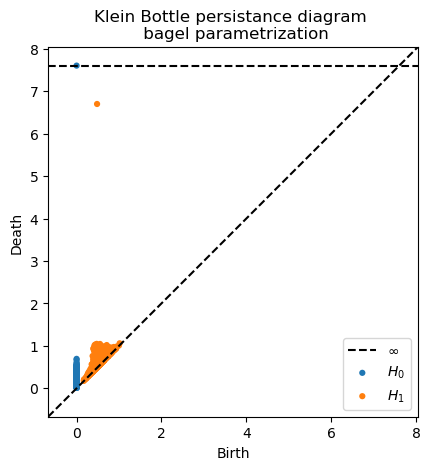

In [31]:
plt.title("Klein Bottle persistance diagram \n bagel parametrization")
plot_diagrams(diagrams, show=True)
# plt.title("(noisy) Klein Bottle persistance diagram \n bagel parametrization")
# plot_diagrams(diagrams_noise, show=True)

In [26]:
num_points = 2000
embedding_dim = 3
intrinsic_dim = 2

task_points = synthetic.hypertorus(intrinsic_dim, num_points)
torus_points = task_points
torus_noisy_points, _ = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=embedding_dim,
    nonlinearity="sigmoid",  #'linear' will cause mean to be negative and will give warning
    scales=gs.array(np.ones(embedding_dim)),
    poisson_multiplier=20,
)

torus_points = torus_points / np.linalg.norm(torus_points, axis=1)[:, None]

In [28]:
np.shape(task_points)

torch.Size([2000, 4])

In [27]:
range_ax = 1.5
pt_size = 2
opacity = 0.3
if embedding_dim == 3:
    plot_feature_neural_spaces(
        torus_points, torus_noisy_points, range_ax, pt_size, opacity
    )

mean firing rate: 99.92 Hz
